In [19]:
import torch
import torch.nn as nn

class ChebyKANLinear(nn.Module):
    def __init__(self, input_dim, output_dim, degree, einsum=True):
        super(ChebyKANLinear, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.einsum = bool(einsum)
        if self.einsum:
            self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
            nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):
        x = torch.tanh(x)
        x = x.view((-1, self.inputdim, 1)).expand(-1, -1, self.degree + 1)
        x = x.acos()
        x *= self.arange
        x = x.cos()

        if self.einsum:
            y = torch.einsum("bid,iod->bo", x, self.cheby_coeffs)
            return y.view(-1, self.outdim)
        else:
            return x

In [20]:
# """
# @author   https://github.com/Boris-73-TA/OrthogPolyKANs
# @author   https://github.com/lif314/X-KANeRF/blob/main/xKANeRF/xKAN/hermite_kan.py
# """

import math
import torch
import torch.nn as nn


class HermiteKANLinear(nn.Module):
    def __init__(self, input_dim, output_dim, degree, einsum=True):
        super(HermiteKANLinear, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.einsum = bool(einsum)
        if self.einsum:
            self.hermite_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
            nn.init.normal_(self.hermite_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        hermite = torch.ones(x.shape[0], self.inputdim, self.degree + 1, device=x.device)
        if self.degree > 0:
            hermite[:, :, 1] = 2 * x
        for i in range(2, self.degree + 1):
            hermite[:, :, i] = 2 * x * hermite[:, :, i - 1].clone() - 2 * (i - 1) * hermite[:, :, i - 2].clone()

        if self.einsum:
            y = torch.einsum('bid,iod->bo', hermite, self.hermite_coeffs)
            return y.view(-1, self.outdim)
        else:
            return hermite


class HermiteFuncKANLinear(nn.Module):
    # https://github.com/Rob217/hermite-functions/blob/master/hermite_functions/hermite_functions.py
    def __init__(self, input_dim, output_dim, degree, eps=1, einsum=True):
        super(HermiteFuncKANLinear, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.eps = eps

        self.einsum = bool(einsum)
        if self.einsum:
            self.hermite_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
            nn.init.normal_(self.hermite_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x) * (math.sqrt(2 * self.degree + 1) + self.eps)
        hermite = torch.ones(x.shape[0], self.inputdim, self.degree + 1, device=x.device)
        hermite[:, :, 0] = math.pi ** (-1 / 4) * torch.exp(-(x ** 2) / 2)
        if self.degree > 0:
            hermite[:, :, 1] = math.sqrt(2) * math.pi ** (-1 / 4) * x * torch.exp(-(x ** 2) / 2)
        for i in range(2, self.degree + 1):
            hermite[:, :, i] = math.sqrt(2 / i) * x * hermite[:, :, i - 1].clone() - math.sqrt((i - 1) / i) * hermite[:, :, i - 2].clone()

        if self.einsum:
            y = torch.einsum('bid,iod->bo', hermite, self.hermite_coeffs)
            return y.view(-1, self.outdim)
        else:
            return hermite


In [21]:
# """
# @author   https://github.com/CUHK-AIM-Group/U-KAN
# """

import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
        einsum=True
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.einsum = einsum

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order: -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    # def forward(self, x: torch.Tensor):
    #     assert x.dim() == 2 and x.size(1) == self.in_features

    #     base_output = F.linear(self.base_activation(x), self.base_weight)
    #     spline_output = F.linear(
    #         self.b_splines(x).view(x.size(0), -1),
    #         self.scaled_spline_weight.view(self.out_features, -1),
    #     )
    #     return base_output + spline_output

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)

        bases = self.b_splines(x)  # (B, I, D)
        
        if not self.einsum:
            return bases  # 仅输出 spline basis，不做加权（用于 attention token）

        weights = self.scaled_spline_weight  # (O, I, D)
        spline_output = torch.einsum("bid,oid->bo", bases, weights)

        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


In [22]:

class AttentionKANLinear(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(AttentionKANLinear, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.subspaces = nn.ModuleList([
            KANLinear(input_dim, output_dim, spline_order=degree, einsum=False),
            ChebyKANLinear(input_dim, output_dim, degree, einsum=False),
            HermiteFuncKANLinear(input_dim, output_dim, degree, einsum=False)
        ])
        # v1.0: Feasibility for Programming and Computer Software 2025.
        # self.mha = nn.MultiheadAttention(input_dim * len(self.subspaces), num_heads=1, batch_first=True)
        # self.proj = nn.Linear(input_dim * len(self.subspaces), output_dim)

        # v1.1: Fix attention map size from \theta x \theta to more interpretable kd x kd, where d is degree + 1.
        # self.mha = nn.MultiheadAttention(input_dim, num_heads=1, batch_first=True)
        # self.coeffs = nn.Parameter(torch.empty(input_dim, output_dim, (degree + 1) * len(self.subspaces)))
        # nn.init.normal_(self.coeffs, mean=0.0, std=1 / (input_dim * (degree + 1) * len(self.subspaces)))

        # v1.2: Interpretable attention map of shape BHW x kd, encoding basis functions distribution over kd basis funcs for each processing patch.
        self.mha = nn.MultiheadAttention(input_dim, num_heads=1, batch_first=True)
        self.proj = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))

        # v1.0
        # x = torch.cat([layer(x) for layer in self.subspaces], dim=-1)
        # x, _ = self.mha(x, x, x)
        # x = self.proj(x)
        # return x.view(-1, self.outdim)

        # v1.1
        # x = torch.cat([layer(x) for layer in self.subspaces], dim=-1).permute(0, 2, 1)
        # x, _ = self.mha(x, x, x)
        # x = x.permute(0, 2, 1)
        # x = torch.einsum('bid,iod->bo', x, self.coeffs)
        # return x.view(-1, self.outdim)

        # v1.2
        q_x = x.unsqueeze(1)
        x = torch.cat([layer(x) for layer in self.subspaces], dim=-1).permute(0, 2, 1)
        x, _ = self.mha(q_x, x, x)
        x = x.squeeze(1)
        x = self.proj(x)
        return x.view(-1, self.outdim)


In [23]:
import torch

# 参数设定
input_dim = 4
output_dim = 3
degree = 5
batch_size = 8

# 构造输入
x = torch.randn(batch_size, input_dim)

# 构造模型
model = AttentionKANLinear(input_dim, output_dim, degree)

# 前向传播
y = model(x)

# 输出信息
print("✅ AttentionKANLinear 测试通过")
print("Input shape:", x.shape)
print("Output shape:", y.shape)
print("NaN in output:", torch.isnan(y).any().item())
print("Inf in output:", torch.isinf(y).any().item())


✅ AttentionKANLinear 测试通过
Input shape: torch.Size([8, 4])
Output shape: torch.Size([8, 3])
NaN in output: False
Inf in output: False


✅ einsum=True:
Output shape: torch.Size([8, 3])
NaN: False | Inf: False

✅ einsum=False (basis expansion only):
Output shape: torch.Size([8, 4, 6])
Expected shape: (batch_size, input_dim, degree+1) = (8, 4, 6)
NaN: False | Inf: False


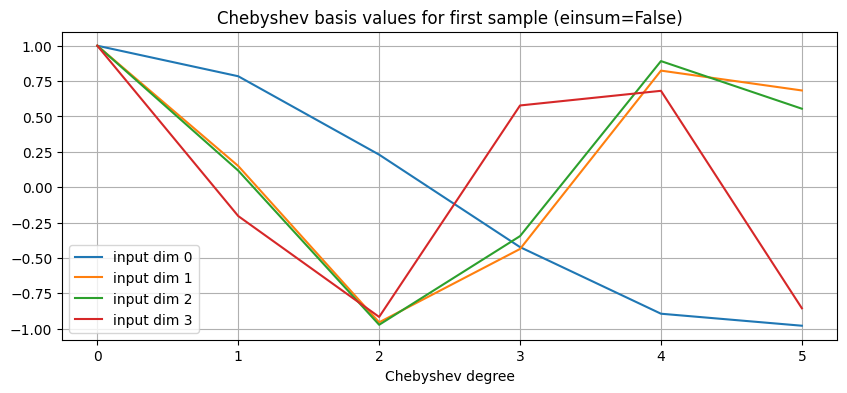

In [2]:
# 测试配置
input_dim = 4
output_dim = 3
degree = 5
batch_size = 8
x = torch.randn(batch_size, input_dim)

# 测试 einsum = True
model_einsum = ChebyKANLinear(input_dim, output_dim, degree, einsum=True)
y1 = model_einsum(x)

print("✅ einsum=True:")
print("Output shape:", y1.shape)
print("NaN:", torch.isnan(y1).any().item(), "| Inf:", torch.isinf(y1).any().item())

# 测试 einsum = False
model_no_einsum = ChebyKANLinear(input_dim, output_dim, degree, einsum=False)
y2 = model_no_einsum(x)

print("\n✅ einsum=False (basis expansion only):")
print("Output shape:", y2.shape)
print("Expected shape: (batch_size, input_dim, degree+1) =", (batch_size, input_dim, degree + 1))
print("NaN:", torch.isnan(y2).any().item(), "| Inf:", torch.isinf(y2).any().item())

# 可视化一个样本的 Chebyshev 多项式展开结果
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(input_dim):
    plt.plot(range(degree+1), y2[0, i].detach().numpy(), label=f'input dim {i}')
plt.title('Chebyshev basis values for first sample (einsum=False)')
plt.xlabel('Chebyshev degree')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# 设置测试参数
in_features = 4
out_features = 3
grid_size = 5
spline_order = 3
batch_size = 8

# 随机输入
x = torch.randn(batch_size, in_features)

# 初始化模型
kan_linear = KANLinear(
    in_features=in_features,
    out_features=out_features,
    grid_size=grid_size,
    spline_order=spline_order,
)

# 前向传播
y = kan_linear(x)

# 检查输出
print("✅ KANLinear 测试:")
print("Output shape:", y.shape)
print("NaN:", torch.isnan(y).any().item(), "| Inf:", torch.isinf(y).any().item())


✅ KANLinear 测试:
Output shape: torch.Size([8, 3])
NaN: False | Inf: False
